In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os

## Preprocess the Data

**Load data**

In [2]:
from SegNet.prepare_ISPRS_dataset import load_tif_3bands

Using TensorFlow backend.


In [3]:
directory_x = "/Users/ikersanchez/Vizzuality/PROIEKTUAK/Skydipper/Data/Potsdam/2_Ortho_RGB/"
directory_y = "/Users/ikersanchez/Vizzuality/PROIEKTUAK/Skydipper/Data/Potsdam/5_Labels_all/"
files_x_train = sorted(os.listdir(directory_x))[:1]
files_y_train = sorted(os.listdir(directory_y))[:1]
files_x_validation = sorted(os.listdir(directory_x))[1:2]
files_y_validation = sorted(os.listdir(directory_y))[1:2]
# Train data
x_train = load_tif_3bands(directory_x, files_x_train)
y_train = load_tif_3bands(directory_y, files_y_train)
# Validation data
x_validation = load_tif_3bands(directory_x, files_x_validation)
y_validation = load_tif_3bands(directory_y, files_y_validation)

/anaconda3/lib/python3.6/site-packages/rasterio/__init__.py:193: UserWarning: Dataset has no geotransform set.  Default transform will be applied (Affine.identity())
  s.start()


**Visualize data**

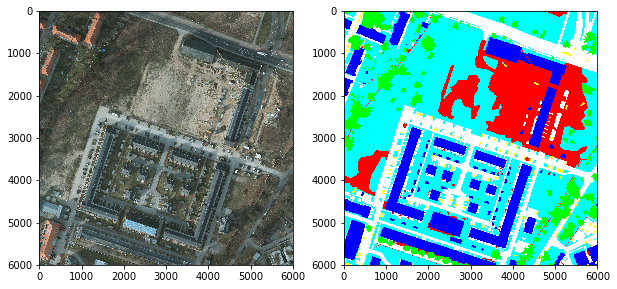

In [4]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax = axs[0]
ax.imshow(x_train[0,:,:,:])

ax = axs[1]
ax.imshow(y_train[0,:,:,:])

**Preprocess class labels for Keras**

Let's take a look at the shape of our class label data:

In [5]:
y_train.shape

(1, 6000, 6000, 3)

In the y_train data the six categories/classes have been defined as:
    1. Impervious surfaces (RGB: 255, 255, 255)
    2. Building (RGB: 0, 0, 255)
    3. Low vegetation (RGB: 0, 255, 255)
    4. Tree (RGB: 0, 255, 0)
    5. Car (RGB: 255, 255, 0)
    6. Clutter/background (RGB: 255, 0, 0)

In [6]:
from SegNet.prepare_ISPRS_dataset import from_rgb_to_categorical

In [7]:
# Convert 1-dimensional class arrays to 6-dimensional class matrices
y_train = from_rgb_to_categorical(y_train)
y_validation = from_rgb_to_categorical(y_validation)

In [8]:
y_train.shape

(1, 6000, 6000, 6)

**Resize the images**

In [9]:
x_train.shape

(1, 6000, 6000, 3)

The input images are very large (6000 x 6000), we resize the images to patches of 200 x 200.

In [10]:
from SegNet.prepare_ISPRS_dataset import resize_patches

In [11]:
# We extract patches of 200×200 pixels
x_train, y_train, x_validation, y_validation = resize_patches(x_train, y_train, x_validation, y_validation, patch_size = 200)

In [12]:
x_train.shape

(900, 200, 200, 3)

We display the location of the `impervious surfaces` in one patch

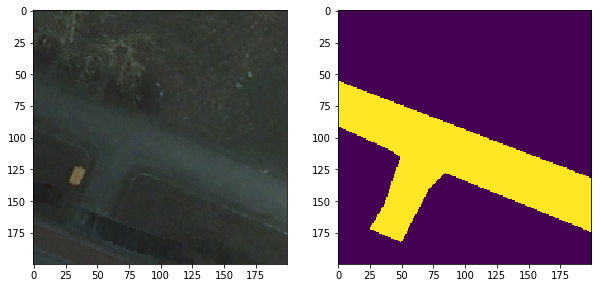

In [13]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax = axs[0]
ax.imshow(x_train[0,:,:,:])

ax = axs[1]
ax.imshow(y_train[0,:,:,0])

**Randomize the datasets**

In [14]:
# We randomize the datasets
stt=x_train.shape[0]
svt=x_validation.shape[0]
arr_t = np.arange(stt)
arr_v = np.arange(svt)
np.random.shuffle(arr_t)
np.random.shuffle(arr_v)

x_train = x_train[arr_t,:,:,:]
y_train = y_train[arr_t,:,:,:]
x_validation = x_validation[arr_v,:,:,:]
y_validation = y_validation[arr_v,:,:,:]

We display the location of the `cars` in one patch

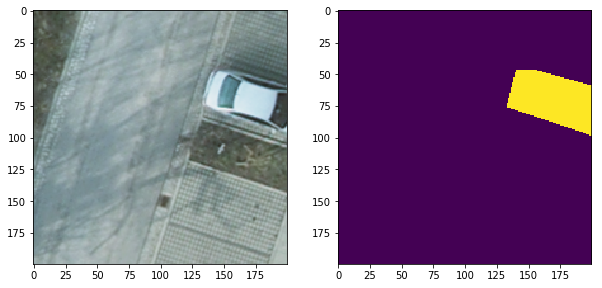

In [20]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax = axs[0]
ax.imshow(x_train[0,:,:,:])

ax = axs[1]
ax.imshow(y_train[0,:,:,4])

**Save samples**

In [16]:
from SegNet.prepare_ISPRS_dataset import write_data

In [17]:
write_data("./SegNet/Samples/x_train.h5", 'x_train', x_train[:64,:,:,:])
write_data("./SegNet/Samples/y_train.h5", 'y_train', y_train[:64,:,:,:])
write_data("./SegNet/Samples/x_validation.h5", 'x_validation', x_validation[:32,:,:,:])
write_data("./SegNet/Samples/y_validation.h5", 'y_validation', y_validation[:32,:,:,:])             

## Train the Network 

To train SegNet from the command line type:

```python
python train_SegNet.py -i Samples/ -o Network/SegNet -e 20 -a start
```

The parameters are:

```
-i = Samples/model 
    Path of the input files.
-o = network/model 
    Path of the output file that will contain the network weights.
-e = 20
    Number of epochs to use during training.
-a = {start,continue}
     `start`: start a new calculation
     `continue`: continue a previous calculation
```

We can also train the network in the jupyter notebook by following the next steps:

In [18]:
from SegNet.train_SegNet import LossHistory, train_segnet

In [19]:
root_in = "SegNet/Samples/"
root_out = "SegNet/Network/SegNet"
nEpochs = 1
option = 'start'

out = train_segnet(root_in, root_out, option)
    
out.read_data()

if (option == 'start'):           
    out.define_network()        
        
if (option == 'continue'):
    out.read_network()

if (option == 'start' or option == 'continue'):
    out.compile_network()
    out.train_network(nEpochs)

Original training set size: 64
   - Final training set size: 64
   - Batch size: 32
   - Batches per epoch: 2
Original validation set size: 32
   - Final validation set size: 32
   - Batch size: 32
   - Batches per epoch: 1
Number of Bands: 3
Number of Classes: 6
Reading data...
Setting up network...
Training network...
Train on 64 samples, validate on 32 samples
Epoch 1/1
64/64 [==============================] - 146s 2s/step - loss: 0.1380 - val_loss: 0.1443

Epoch 00001: val_loss improved from inf to 0.14427, saving model to SegNet/Network/SegNet_weights.hdf5


## Predict

To use SegNet from the command line type:

```python
python SegNet.py -i Sample/x_validation.h5 -o Predictions/output.h5 -c 6
```

The parameters are:

```
-i = Samples/model 
    Path of the input file.
-o = network/model 
    Path of the output file.
-c = 6
    Number of classes.
```

In [21]:
from SegNet.SegNet import segnet

In [22]:
input_path = 'SegNet/Samples/x_validation.h5'
output_path = 'SegNet/Predictions/output.h5'
nClasses = 6


# Open file with observations and read them. We use h5 in our case
f = h5py.File(input_path, 'r')
imgs = f.get("x_validation") 

prediction = segnet(imgs, output_path, nClasses)
prediction.define_network()
out = prediction.predict()
f.close()

Image size: 200x200
Number of images: 32
Setting up network...
Segmenting images with SegNet...
Prediction took 2.4e+01 seconds...
Saving data...


We display the ground truth and the prediction:

In [23]:
# Open file with observations and read them. We use h5 in our case
f = h5py.File('/Users/ikersanchez/Vizzuality/GitHub/Skydipper/cnn-models/SegNet/Samples/x_validation.h5', 'r')
x = f.get("x_validation") 
f = h5py.File('/Users/ikersanchez/Vizzuality/GitHub/Skydipper/cnn-models/SegNet/Samples/y_validation.h5', 'r')
y = f.get("y_validation") 
f = h5py.File('/Users/ikersanchez/Vizzuality/GitHub/Skydipper/cnn-models/SegNet/Predictions/output.h5', 'r')
output = f.get("out") 

Text(0.5,1,'Prediction')

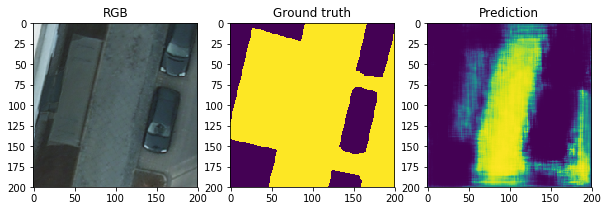

In [37]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10,5))
ax = axs[0]
ax.imshow(x[5,:,:,:])
ax.set_title('RGB')

ax = axs[1]
ax.imshow(y[5,:,:,0])
ax.set_title('Ground truth')

ax = axs[2]
ax.imshow(output[5,:,:,0])
ax.set_title('Prediction')